# Adding Neo4j query functionality to `nc3rsEDA`

This notebook is focused on adding the ability to directly query a database using the Python Neo4j API driver, `neo4j`.

Up to this point, the custom `nc3rsEDA` has the ability to read in a `.eda` file and generate visualization, a Cypher CREATE query, and Arrows.app JSON for playing with the schema outside of the Experimental Design Assistant.

Next, it should be straightforward to run the query in the wrapper. This ultimately depends more on the backend being functional, i.e., 
- Database is standing up and accessible (might need to name and register a static address), add unit test
- UIDs for each node and relationship need to be unique in the database (is this automatic?), add unit test
- Generate Version labels in case the EDA file is updated?

For now, though, let's just try to automate running the query.

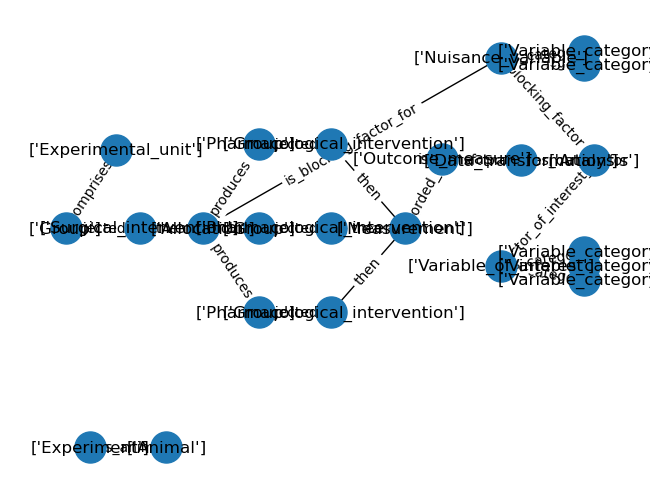

In [1]:
import nc3rsEDA as ned
g = ned.Graph('model')
g.visualize()

In [2]:
fstr = g.fstr_neo4j_create()
print(fstr)

CREATE (n0:Measurement {description: null, timing: "1h after THC/veh injection", blind_measurement: "animals individually coded", reason_for_not_blinding: null, additional_information: "average temperature over 5 min", text: "Measurement : body temperature"}),
(n1:Pharmacological_intervention {description: "Vehicle", drug_and_dose: "20% DMSO, 1 ml", mode_of_administration: "intraperitoneal", mode_of_administration_if_other: null, adverse_effects: "none expected", timing: null, additional_information: null, text: "Pharmacological intervention 1"}),
(n2:Pharmacological_intervention {description: null, drug_and_dose: "THC 1mg/kg", mode_of_administration: "intraperitoneal", mode_of_administration_if_other: null, adverse_effects: "impaired coordination, dizziness", timing: null, additional_information: null, text: "Pharmacological intervention 2"}),
(n3:Pharmacological_intervention {description: null, drug_and_dose: "THC 3 mg/kg", mode_of_administration: "intraperitoneal", mode_of_administr

In [3]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
auth = ("neo4j", "neo4jiscool")

with GraphDatabase.driver(uri, auth=auth) as driver:
    driver.verify_connectivity()

In [4]:
def detach_delete(tx):
    result = tx.run(f"""MATCH (n) DETACH DELETE n;""")
    records = list(result)
    summary = result.consume()
    return records, summary

def create_eda_record(tx, eda_graph):
    result = tx.run(f"""{eda_graph.fstr_neo4j_create()}""")
    records = list(result)
    summary = result.consume()
    return records, summary

# driver.close()  # close the driver object

In [5]:
with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session(database="neo4j") as session:
        records, summary = session.execute_write(detach_delete)
        for _k, _v in summary.metadata['stats'].items():
            print(f"{_k:25s} {_v:3d}")

nodes-deleted              23
relationships-deleted      24


In [6]:
with GraphDatabase.driver(uri, auth=auth) as driver:
    with driver.session(database="neo4j") as session:
        records, summary = session.execute_write(create_eda_record,
                                                 eda_graph=g)
        for _k, _v in summary.metadata['stats'].items():
            print(f"{_k:25s} {_v:3d}")

labels-added               23
relationships-created      24
nodes-created              23
properties-set             93


In [7]:
summary.metadata['stats']['labels-added']

23

After testing out the above, I created a new class, `Neo4jWriter` in the `nc3rsEDA` package. This provides a simpler API to cover basic functionality for the EDA ETL.

In [8]:
neoned = ned.Neo4jWriter(g)

In [9]:
neoned.detach_delete_all()

nodes-deleted              23
relationships-deleted      24


In [10]:
neoned.write()

labels-added               23
relationships-created      24
nodes-created              23
properties-set             93


As far as I can tell, it's working now, so this Python package has reached MVP status for this stage of development!